# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Mean Reversion Strategy on EWA and EWC

In [3]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
%matplotlib inline
plt.style.use('seaborn-darkgrid')

In [4]:
x = pd.read_csv('EWA.csv',index_col=0)['Close']
y = pd.read_csv('EWC.csv',index_col=0)['Close']

In [5]:
df = pd.concat([x,y],axis=1)
df.columns = ['EWA','EWC']
df.index = pd.to_datetime(df.index)

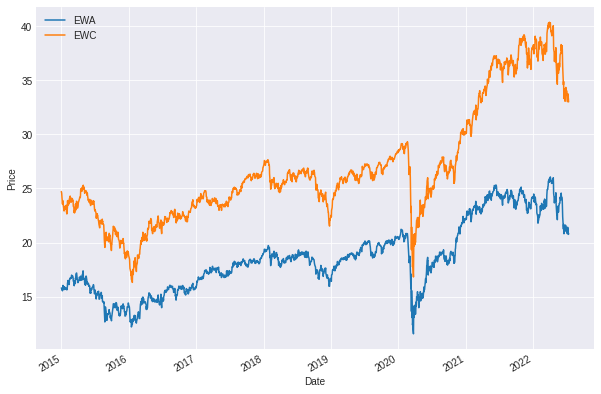

In [6]:
df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.show()

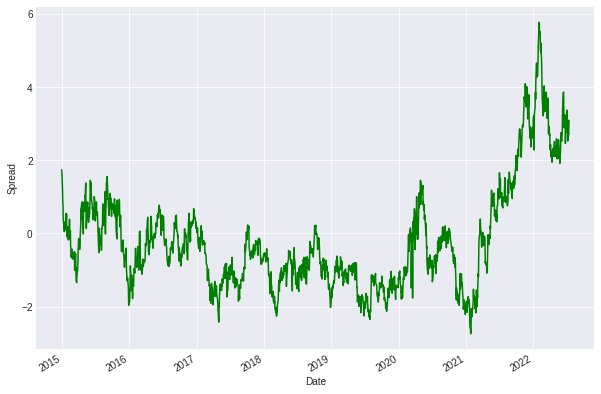

In [7]:
from statsmodels.api import OLS
model = OLS(df.EWC.iloc[:90], df.EWA.iloc[:90])
model = model.fit() 
df['spread'] = df.EWC - model.params[0] * df.EWA

# Plot the spread
df.spread.plot(figsize=(10,7), color='g')
plt.ylabel("Spread")

plt.show()

In [14]:
model.params[0]

1.4543214951753136

## Mean reversion strategy function

This function computes the positions on the basis of the spread, lookback period and the standard deviation.

In [8]:
def mean_reversion_strategy(df, lookback, std_dev):

    # Moving Average
    df['moving_average'] = df.spread.rolling(lookback).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    # Upper band and lower band
    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    # Long positions
    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average

    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    # Short positions
    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average

    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0

    df.positions_short = df.positions_short.fillna(method='ffill')

    # Positions
    df['positions'] = df.positions_long + df.positions_short

    return df

In [9]:
df = mean_reversion_strategy(df, 30, 2)

## Cumulative returns

In [10]:
df['percentage_change'] = (df.spread - df.spread.shift(1))/(model.params[0]*df.EWA + df.EWC)
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 42.47'

In [11]:
s = np.mean(df['strategy_returns'])/np.std(df['strategy_returns'])*(252**0.5)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio 1.03'

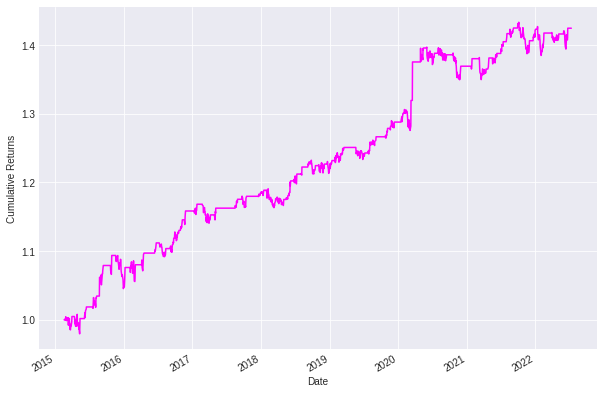

In [12]:
df.cumulative_returns.plot(label='Returns', figsize=(10,7),color='magenta')  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

The maximum drawdown is -4.41


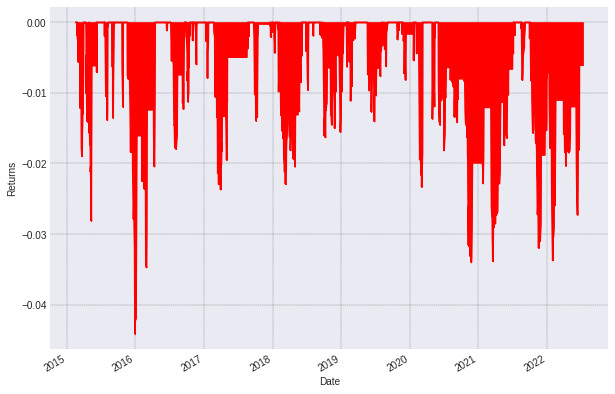

In [13]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()
    
drawdown = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)

Next step: Try this strategy on HDFC and HDFC Bank.